<a href="https://colab.research.google.com/github/BalthazazarDuc/MasterThesis/blob/main/Copie_de_MasterThesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [4]:
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import geopandas as gpd
import numpy as np
import random
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
GO_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/GO-Prices_Aggregated_v02%20.csv", sep=";", decimal = ",")
carbon_intensity = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/carbon-intensity-electricity.csv")
CI_PV = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/carbon_intensity_rooftop.csv")


In [6]:
#E_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/estat_ten00117_filtered_en.csv")
#E_price2 = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/electrcity_price.csv")
E_price = pd.read_csv("https://raw.githubusercontent.com/BalthazazarDuc/MasterThesis/refs/heads/main/european_wholesale_electricity_price_data_monthly.csv")
#We use the last one that come from Amber website

##GO_price data cleaning

In [7]:
GO_price.columns = GO_price.iloc[0]
GO_price=GO_price[1:]

In [8]:

german_to_english = {
    "Belgien": "Belgium",
    "Dänemark": "Denmark",
    "Deutschland": "Germany",
    "Estland": "Estonia",
    "Finnland": "Finland",
    "Frankreich": "France",
    "Griechenland": "Greece",
    "Irland": "Ireland",
    "Island": "Iceland",
    "Italien": "Italy",
    "Kroatien": "Croatia",
    "Litauen": "Lithuania",
    "Luxemburg": "Luxembourg",
    "Niederlande": "Netherlands",
    "Norwegen": "Norway",
    "Österreich": "Austria",
    "Portugal": "Portugal",
    "Schweden": "Sweden",
    "Schweiz": "Switzerland",
    "Serbien": "Serbia",
    "Slowakei": "Slovakia",
    "Slowenien": "Slovenia",
    "Spanien": "Spain",
    "Tschechien": "Czech Republic",
    "Zypern": "Cyprus",
    "(Leer)": "Unknown"  # or you can use None or drop it depending on your case
}

# Apply the replacement to the 'Land' column
GO_price['Land'] = GO_price['Land'].replace(german_to_english)

GO_price = GO_price.iloc[:, :7]
GO_price = GO_price.rename(columns={'Land': 'Country'})
GO_price = GO_price.rename(columns={'Technologie': 'Technology'})
GO_price

/tmp/ipython-input-8-3135819221.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GO_price['Land'] = GO_price['Land'].replace(german_to_english)


,Country,Technology,2020.0,2021.0,2022.0,2023.0,2024.0
1,Belgium,Biomass,1.754156,1.763370,1.926258,1.987911,1.987911
2,Belgium,Geothermal,47.457627,46.949153,46.440678,45.932203,45.423729
3,Belgium,Hydro,1.036734,1.108711,1.156500,1.192359,1.292590
4,Belgium,Other RES,47.457627,46.949153,46.440678,45.932203,45.423729
5,Belgium,Solar,7.647210,7.647210,10.408500,10.408500,11.633309
...,...,...,...,...,...,...,...
147,Cyprus,Hydro,47.457627,46.949153,46.440678,45.932203,45.423729
148,Cyprus,Other RES,47.457627,46.949153,46.440678,45.932203,45.423729
149,Cyprus,Solar,47.457627,46.949153,46.440678,45.932203,45.423729
150,Cyprus,Wind,2.653950,2.804310,2.904840,3.009990,3.206250


In [9]:
# Step 1: Melt the dataset so years become a column
GO_price_melted = GO_price.melt(
    id_vars=['Country', 'Technology'],
    var_name='Year',
    value_name='Value'
)

# Step 2: Convert Year to integer (if needed)
#GO_price_melted['Year'] = GO_price_melted['Year'].astype(int)

# Step 3: Pivot so Technologie becomes columns
GO_price_pivoted = GO_price_melted.pivot_table(
    index=['Country', 'Year'],
    columns='Technology',
    values='Value'
).reset_index()

GO_price_filtered = GO_price_pivoted[['Country', 'Year', 'Solar', 'Wind']]

GO_price_filtered = GO_price_filtered.dropna()
GO_price_filtered = GO_price_filtered[GO_price_filtered['Year'] <= 2024]

GO_price_filtered

Technology,Country,Year,Solar,Wind
0,Austria,2020.0,47.457627,4.096445
1,Austria,2021.0,46.949153,4.096445
2,Austria,2022.0,46.440678,4.096445
3,Austria,2023.0,45.932203,4.096445
4,Austria,2024.0,45.423729,4.096445
...,...,...,...,...
120,Switzerland,2020.0,12.779427,4.853385
121,Switzerland,2021.0,12.779427,4.853385
122,Switzerland,2022.0,12.779427,4.853385
123,Switzerland,2023.0,12.779427,4.853385


##Carbon_intensity electrcity data cleaning

In [10]:
# Step 1: Use the English country names from the dictionary
english_country_names = list(german_to_english.values())

# Step 2: Filter the carbon_intensity DataFrame
carbon_intensity = carbon_intensity[carbon_intensity['Entity'].isin(english_country_names)]
carbon_intensity = carbon_intensity.rename(columns={'Entity': 'Country'})
carbon_intensity

,Country,Code,Year,Carbon intensity of electricity - gCO2/kWh
350,Austria,AUT,1990,249.847780
351,Austria,AUT,1991,262.759200
352,Austria,AUT,1992,201.643630
353,Austria,AUT,1993,183.589940
354,Austria,AUT,1994,196.150130
...,...,...,...,...
5137,Switzerland,CHE,2019,33.867085
5138,Switzerland,CHE,2020,35.041615
5139,Switzerland,CHE,2021,37.083992
5140,Switzerland,CHE,2022,36.132970


In [11]:
E_price = E_price.rename(columns={'ISO3 Code': 'Code'})
E_price.head(50)


,Country,Code,Date,Price (EUR/MWhe)
0,Austria,AUT,2015-01-01,29.94
1,Belgium,BEL,2015-01-01,42.33
2,Czechia,CZE,2015-01-01,29.47
3,Denmark,DNK,2015-01-01,27.12
4,Estonia,EST,2015-01-01,33.84
5,Finland,FIN,2015-01-01,33.81
6,France,FRA,2015-01-01,40.94
7,Germany,DEU,2015-01-01,29.94
8,Greece,GRC,2015-01-01,61.41
9,Hungary,HUN,2015-01-01,42.16


In [12]:
# Step 1: Convert 'Date' to datetime format
E_price['Date'] = pd.to_datetime(E_price['Date'])

# Step 2: Extract year into a new column
E_price['Year'] = E_price['Date'].dt.year

# Step 3: Group by Country and Year, and calculate mean price
yearly_price = E_price.groupby(['Country', 'Year', 'Code'])['Price (EUR/MWhe)'].mean().reset_index()
yearly_price

,Country,Year,Code,Price (EUR/MWhe)
0,Austria,2015,AUT,31.764167
1,Austria,2016,AUT,28.956667
2,Austria,2017,AUT,34.419167
3,Austria,2018,AUT,40.891667
4,Austria,2019,AUT,40.137500
...,...,...,...,...
324,United Kingdom,2021,GBR,136.991667
325,United Kingdom,2022,GBR,239.865000
326,United Kingdom,2023,GBR,108.526667
327,United Kingdom,2024,GBR,85.785833


##Carbon Intensity Solar

*   Élément de liste
*   Élément de liste



In [13]:
CI_PV.head()

,Country,Country code,Capital,CI electricity mix (gCO2-eq/kWh),S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh)
0,Austria,AT,"Vienna (48.2°N, 16.4°E)",264,35.1,42.0,50.2,72.2,211.0
1,Belgium,BE,"Brussels (50.8°N, 4.4°E)",230,40.1,47.9,56.0,80.8,206.9
2,Bulgaria,BG,"Sofia (42.6°N, 24°E)",544,30.8,37.4,48.1,69.9,190.6
3,Cyprus,CY,"Nicosia (35.1°N, 33.2°E)",791,25.5,28.9,41.8,55.1,192.0
4,Czechia,CZ,"Prague (50°N, 14.5°E)",564,38.3,45.5,54.4,78.1,214.8


In [14]:
def extract_latitude_from_capital(capital_string):
    if pd.isna(capital_string):
        return None

    try:
        # Print first few for debugging
        print(f"Processing: {capital_string}")

        # Try different patterns
        patterns = [
            r'(\d+\.?\d*)°N',           # 48.2°N
            r'(\d+\.?\d*)\s*°\s*N',     # 48.2 ° N
            r'(\d+\.?\d*)\s*N',         # 48.2 N
            r'(\d+\.?\d*),\s*\d+\.?\d*', # 48.2, 16.4 (assuming lat, lon)
        ]

        for pattern in patterns:
            lat_match = re.search(pattern, str(capital_string))
            if lat_match:
                latitude = float(lat_match.group(1))
                print(f"  → Found latitude: {latitude}")
                return latitude

        print(f"  → No latitude found")
        return None

    except Exception as e:
        print(f"  → Error: {e}")
        return None

In [15]:
CI_PV['Latitude'] = CI_PV['Capital'].apply(extract_latitude_from_capital)
CI_PV

Processing: Vienna (48.2°N, 16.4°E)
  → Found latitude: 48.2
Processing: Brussels (50.8°N, 4.4°E)
  → Found latitude: 50.8
Processing: Sofia (42.6°N, 24°E)
  → Found latitude: 42.6
Processing: Nicosia (35.1°N, 33.2°E)
  → Found latitude: 35.1
Processing: Prague (50°N, 14.5°E)
  → Found latitude: 50.0
Processing: Berlin (52.5°N, 13.4°E)
  → Found latitude: 52.5
Processing: Copenhagen (55.7°N, 12.6°E)
  → Found latitude: 55.7
Processing: Tallinn (59.4°N, 24.8°E)
  → Found latitude: 59.4
Processing: Athens (38°N, 23.7°E)
  → Found latitude: 38.0
Processing: Madrid (40.4°N, 3.7°W)
  → Found latitude: 40.4
Processing: Helsinki (60.2°N, 24.9°E)
  → Found latitude: 60.2
Processing: Paris (48.9°N, 2.3°E)
  → Found latitude: 48.9
Processing: Zagreb (45.8°N, 16°E)
  → Found latitude: 45.8
Processing: Budapest (47.5°N, 19.1°E)
  → Found latitude: 47.5
Processing: Dublin (53.3°N, 6.3°E)
  → Found latitude: 53.3
Processing: Rome (41.9°N, 12.5°E)
  → Found latitude: 41.9
Processing: Riga (56.9°N, 24

,Country,Country code,Capital,CI electricity mix (gCO2-eq/kWh),S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,AT,"Vienna (48.2°N, 16.4°E)",264,35.1,42.0,50.2,72.2,211.0,48.2
1,Belgium,BE,"Brussels (50.8°N, 4.4°E)",230,40.1,47.9,56.0,80.8,206.9,50.8
2,Bulgaria,BG,"Sofia (42.6°N, 24°E)",544,30.8,37.4,48.1,69.9,190.6,42.6
3,Cyprus,CY,"Nicosia (35.1°N, 33.2°E)",791,25.5,28.9,41.8,55.1,192.0,35.1
4,Czechia,CZ,"Prague (50°N, 14.5°E)",564,38.3,45.5,54.4,78.1,214.8,50.0
5,Germany,DE,"Berlin (52.5°N, 13.4°E)",422,39.0,47.3,54.2,79.9,215.1,52.5
6,Denmark,DK,"Copenhagen (55.7°N, 12.6°E)",158,39.8,48.3,54.5,77.6,220.5,55.7
7,Estonia,EE,"Tallinn (59.4°N, 24.8°E)",472,46.0,56.5,62.8,88.1,248.6,59.4
8,Greece,EL,"Athens (38°N, 23.7°E)",780,26.1,29.1,43.2,51.1,191.1,38.0
9,Spain,ES,"Madrid (40.4°N, 3.7°W)",279,25.5,30.4,38.3,54.8,207.0,40.4


In [16]:
#GO_price['Land'].unique()
CI_PV = CI_PV.drop(columns=['Country code', 'CI electricity mix (gCO2-eq/kWh)', 'Capital'])
CI_PV.head()


,Country,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,35.1,42.0,50.2,72.2,211.0,48.2
1,Belgium,40.1,47.9,56.0,80.8,206.9,50.8
2,Bulgaria,30.8,37.4,48.1,69.9,190.6,42.6
3,Cyprus,25.5,28.9,41.8,55.1,192.0,35.1
4,Czechia,38.3,45.5,54.4,78.1,214.8,50.0


In [17]:
df1 = pd.merge(
    yearly_price,
    carbon_intensity,
    on=['Country', 'Code', 'Year'],
    how='inner'  # Use 'inner' to keep only common matches
)

In [18]:
df=pd.merge(df1, CI_PV, on=['Country'], how='inner')
GO_price = 5
df

,Country,Year,Code,Price (EUR/MWhe),Carbon intensity of electricity - gCO2/kWh,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,2015,AUT,31.764167,172.062160,35.1,42.0,50.2,72.2,211.0,48.2
1,Austria,2016,AUT,28.956667,154.616910,35.1,42.0,50.2,72.2,211.0,48.2
2,Austria,2017,AUT,34.419167,162.915500,35.1,42.0,50.2,72.2,211.0,48.2
3,Austria,2018,AUT,40.891667,157.878460,35.1,42.0,50.2,72.2,211.0,48.2
4,Austria,2019,AUT,40.137500,152.779740,35.1,42.0,50.2,72.2,211.0,48.2
...,...,...,...,...,...,...,...,...,...,...,...
187,Switzerland,2019,CHE,40.951667,33.867085,34.7,41.3,49.4,73.1,205.2,46.9
188,Switzerland,2020,CHE,33.988333,35.041615,34.7,41.3,49.4,73.1,205.2,46.9
189,Switzerland,2021,CHE,114.569167,37.083992,34.7,41.3,49.4,73.1,205.2,46.9
190,Switzerland,2022,CHE,280.995833,36.132970,34.7,41.3,49.4,73.1,205.2,46.9


In [19]:
df.head(50)


,Country,Year,Code,Price (EUR/MWhe),Carbon intensity of electricity - gCO2/kWh,S-opta (gCO2-eq/kWh),Flat roof (gCO2-eq/kWh),S-90° (gCO2-eq/kWh),W-90° (gCO2-eq/kWh),N-90° (gCO2-eq/kWh),Latitude
0,Austria,2015,AUT,31.764167,172.06216,35.1,42.0,50.2,72.2,211.0,48.2
1,Austria,2016,AUT,28.956667,154.61691,35.1,42.0,50.2,72.2,211.0,48.2
2,Austria,2017,AUT,34.419167,162.91550,35.1,42.0,50.2,72.2,211.0,48.2
3,Austria,2018,AUT,40.891667,157.87846,35.1,42.0,50.2,72.2,211.0,48.2
4,Austria,2019,AUT,40.137500,152.77974,35.1,42.0,50.2,72.2,211.0,48.2
5,Austria,2020,AUT,33.090833,133.40092,35.1,42.0,50.2,72.2,211.0,48.2
6,Austria,2021,AUT,107.598333,136.02280,35.1,42.0,50.2,72.2,211.0,48.2
7,Austria,2022,AUT,262.435000,141.78987,35.1,42.0,50.2,72.2,211.0,48.2
8,Austria,2023,AUT,102.389167,110.81243,35.1,42.0,50.2,72.2,211.0,48.2
9,Belgium,2015,BEL,44.691667,215.40260,40.1,47.9,56.0,80.8,206.9,50.8


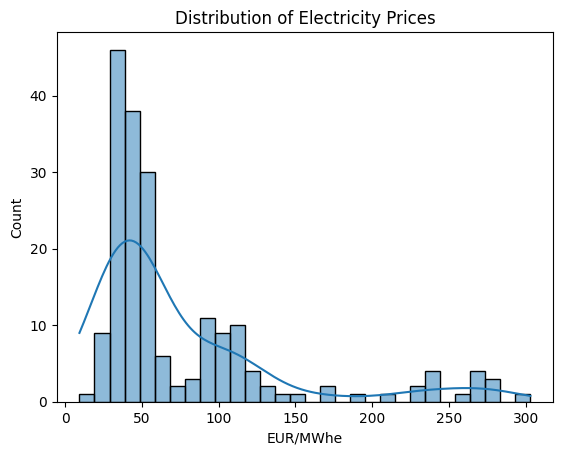

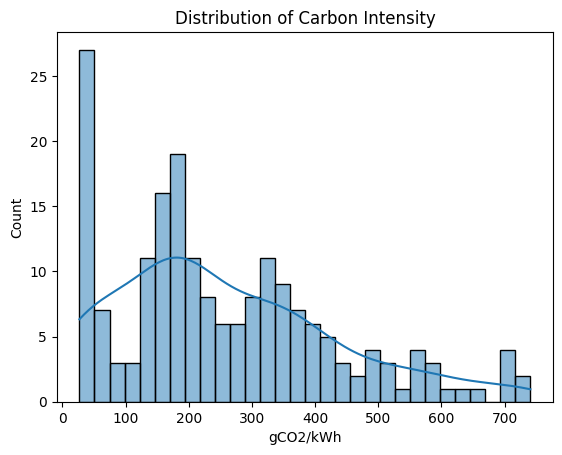

In [20]:

sns.histplot(df['Price (EUR/MWhe)'], bins=30, kde=True)
plt.title('Distribution of Electricity Prices')
plt.xlabel('EUR/MWhe')
plt.show()

# Carbon intensity distribution
sns.histplot(df['Carbon intensity of electricity - gCO2/kWh'], bins=30, kde=True)
plt.title('Distribution of Carbon Intensity')
plt.xlabel('gCO2/kWh')
plt.show()


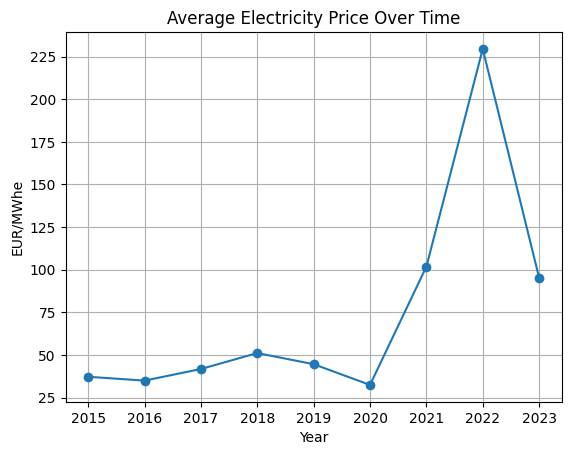

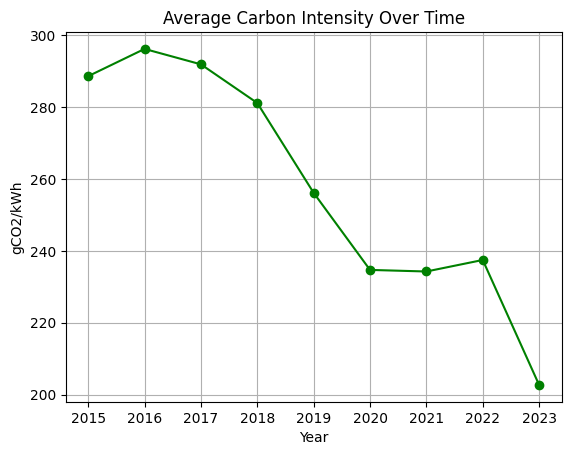

In [21]:
# Average price over years
df.groupby('Year')['Price (EUR/MWhe)'].mean().plot(marker='o')
plt.title('Average Electricity Price Over Time')
plt.ylabel('EUR/MWhe')
plt.grid(True)
plt.show()

# Average carbon intensity over years
df.groupby('Year')['Carbon intensity of electricity - gCO2/kWh'].mean().plot(marker='o', color='green')
plt.title('Average Carbon Intensity Over Time')
plt.ylabel('gCO2/kWh')
plt.grid(True)
plt.show()


#Multiple year cluster analysis

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def cluster_countries_multi_year(df, n_clusters=4):
    """
    Cluster countries based on 2019-2024 averages of:
    - Electricity Price
    - Grid Carbon Intensity
    - Latitude (constant)

    Excludes Serbia from clustering process.
    """
    print("🌍 MULTI-YEAR CLUSTERING (2019-2024)")
    print("="*60)

    # Define years and excluded countries
    years = [2019, 2020, 2021, 2022, 2023, 2024]
    exclude_countries = ['Serbia']

    print(f"Years included: {years[0]}-{years[-1]}")
    print(f"Excluded countries: {', '.join(exclude_countries)}")

    # Filter for selected years
    df_years = df[df['Year'].isin(years)].copy()

    # Calculate country averages
    country_features = []

    for country in df_years['Country'].unique():
        country_data = df_years[df_years['Country'] == country]

        # Skip if insufficient data
        if len(country_data) < 3:  # Require at least 3 years
            print(f"⚠️  Skipping {country}: Only {len(country_data)} years of data")
            continue

        # Calculate features
        features = {
            'Country': country,
            'Avg_Price': country_data['Price (EUR/MWhe)'].mean(),
            'Avg_Grid_CI': country_data['Carbon intensity of electricity - gCO2/kWh'].mean(),
            'Latitude': country_data['Latitude'].iloc[0],
            # Additional stats for context
            'Price_Std': country_data['Price (EUR/MWhe)'].std(),
            'Years_Data': len(country_data)
        }

        country_features.append(features)

    features_df = pd.DataFrame(country_features)
    print(f"\nCountries with sufficient data: {len(features_df)}")

    # Separate Serbia from clustering
    serbia_df = features_df[features_df['Country'] == 'Serbia'].copy()
    clustering_df = features_df[features_df['Country'] != 'Serbia'].copy()

    if len(serbia_df) > 0:
        print(f"\nSerbia excluded from clustering:")
        print(f"  Price: {serbia_df['Avg_Price'].values[0]:.1f} EUR/MWh")
        print(f"  Grid CI: {serbia_df['Avg_Grid_CI'].values[0]:.0f} gCO2/kWh")
        print(f"  Latitude: {serbia_df['Latitude'].values[0]:.1f}°N")

    # Prepare features for clustering
    feature_cols = ['Latitude', 'Avg_Grid_CI', 'Avg_Price']
    X = clustering_df[feature_cols].values

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Test different k values if n_clusters='auto'
    if n_clusters == 'auto':
        scores = {}
        for k in range(2, 7):
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_scaled)
            scores[k] = silhouette_score(X_scaled, labels)

        n_clusters = max(scores, key=scores.get)
        print(f"\nOptimal clusters: {n_clusters} (silhouette: {scores[n_clusters]:.3f})")
        print(f"All scores: {scores}")

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)
    clustering_df['Cluster'] = clusters

    # Assign Serbia to nearest cluster
    if len(serbia_df) > 0:
        serbia_features = serbia_df[feature_cols].values
        serbia_scaled = scaler.transform(serbia_features)
        serbia_cluster = kmeans.predict(serbia_scaled)[0]
        serbia_df['Cluster'] = serbia_cluster
        print(f"\nSerbia assigned to Cluster {serbia_cluster}")

    # Combine results
    final_df = pd.concat([clustering_df, serbia_df], ignore_index=True)

    # Print cluster summary
    print("\n" + "="*60)
    print("CLUSTER RESULTS")
    print("="*60)

    for cluster in range(n_clusters):
        cluster_data = final_df[final_df['Cluster'] == cluster]
        countries = sorted(cluster_data['Country'].tolist())

        print(f"\nCluster {cluster} ({len(countries)} countries):")
        print(f"  Countries: {', '.join(countries)}")
        if 'Serbia' in countries:
            print(f"  ⚠️  Contains outlier: Serbia")

        print(f"  Averages:")
        print(f"    • Price: {cluster_data['Avg_Price'].mean():.1f} EUR/MWh")
        print(f"    • Grid CI: {cluster_data['Avg_Grid_CI'].mean():.0f} gCO2/kWh")
        print(f"    • Latitude: {cluster_data['Latitude'].mean():.1f}°N")

    # Create visualizations
    create_visualizations(final_df, n_clusters)

    # Update original dataframe
    country_cluster_map = dict(zip(final_df['Country'], final_df['Cluster']))
    df['Cluster'] = df['Country'].map(country_cluster_map)

    print(f"\n✅ Clustering complete!")

    return df, final_df

def create_visualizations(df, n_clusters):
    """
    Create visualization plots for the clusters
    """
    colors = sns.color_palette('husl', n_clusters)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: Latitude vs Grid CI
    ax1 = axes[0, 0]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]

        # Separate Serbia
        regular = cluster_data[cluster_data['Country'] != 'Serbia']
        serbia = cluster_data[cluster_data['Country'] == 'Serbia']

        ax1.scatter(regular['Latitude'], regular['Avg_Grid_CI'],
                   c=[colors[cluster]], label=f'Cluster {cluster}', s=100, alpha=0.7)

        if len(serbia) > 0:
            ax1.scatter(serbia['Latitude'], serbia['Avg_Grid_CI'],
                       c=[colors[cluster]], marker='X', s=200,
                       edgecolors='black', linewidths=2)

    ax1.set_xlabel('Latitude (°N)')
    ax1.set_ylabel('Avg Grid CI (gCO2/kWh)')
    ax1.set_title('Geographic Location vs Carbon Intensity')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Grid CI vs Price with country labels
    ax2 = axes[0, 1]
    for cluster in range(n_clusters):
        cluster_data = df[df['Cluster'] == cluster]
        ax2.scatter(cluster_data['Avg_Grid_CI'], cluster_data['Avg_Price'],
                   c=[colors[cluster]], label=f'Cluster {cluster}', s=100, alpha=0.7)

        # Add country labels
        for _, row in cluster_data.iterrows():
            if row['Country'] == 'Serbia':
                ax2.annotate('**SERBIA**', (row['Avg_Grid_CI'], row['Avg_Price']),
                            xytext=(3, 3), textcoords='offset points',
                            fontsize=8, weight='bold', color='red')
            else:
                ax2.annotate(row['Country'], (row['Avg_Grid_CI'], row['Avg_Price']),
                            xytext=(3, 3), textcoords='offset points', fontsize=7)

    ax2.set_xlabel('Avg Grid CI (gCO2/kWh)')
    ax2.set_ylabel('Avg Price (EUR/MWh)')
    ax2.set_title('Carbon Intensity vs Electricity Price')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Cluster sizes
    ax3 = axes[1, 0]
    cluster_sizes = df['Cluster'].value_counts().sort_index()
    bars = ax3.bar(range(n_clusters), cluster_sizes.values, color=colors, alpha=0.7)

    for bar, size in zip(bars, cluster_sizes.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                str(size), ha='center', va='bottom')

    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Number of Countries')
    ax3.set_title('Countries per Cluster')
    ax3.set_xticks(range(n_clusters))
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Feature comparison
    ax4 = axes[1, 1]

    # Normalize features for comparison
    features = ['Avg_Price', 'Avg_Grid_CI', 'Latitude']
    cluster_means = df.groupby('Cluster')[features].mean()

    # Create grouped bar chart
    x = np.arange(len(features))
    width = 0.8 / n_clusters

    for i in range(n_clusters):
        # Normalize values to percentage of maximum
        values = cluster_means.iloc[i] / df[features].max() * 100
        ax4.bar(x + i * width, values, width,
                label=f'Cluster {i}', color=colors[i], alpha=0.7)

    ax4.set_xlabel('Features')
    ax4.set_ylabel('% of Maximum')
    ax4.set_title('Normalized Feature Comparison')
    ax4.set_xticks(x + width * (n_clusters - 1) / 2)
    ax4.set_xticklabels(['Price', 'Grid CI', 'Latitude'])
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Simple usage function
def run_clustering(df):
    """
    Simple wrapper to run the clustering with default settings
    """
    # Run with 4 clusters by default, or use 'auto' to find optimal
    return cluster_countries_multi_year(df, n_clusters=4)

# Example usage:
# df, results = run_clustering(df)
# Or specify clusters:
# df, results = cluster_countries_multi_year(df, n_clusters=5)
# Or find optimal:
# df, results = cluster_countries_multi_year(df, n_clusters='auto')

🌍 MULTI-YEAR CLUSTERING (2019-2024)
Years included: 2019-2024
Excluded countries: Serbia

Countries with sufficient data: 22

Serbia excluded from clustering:
  Price: 115.9 EUR/MWh
  Grid CI: 683 gCO2/kWh
  Latitude: 44.8°N

Optimal clusters: 5 (silhouette: 0.511)
All scores: {2: np.float64(0.4721454055288077), 3: np.float64(0.36443355387757753), 4: np.float64(0.42630227703776), 5: np.float64(0.5111563554635156), 6: np.float64(0.4781029422724307)}

Serbia assigned to Cluster 0

CLUSTER RESULTS

Cluster 0 (5 countries):
  Countries: Estonia, Germany, Ireland, Netherlands, Serbia
  ⚠️  Contains outlier: Serbia
  Averages:
    • Price: 104.6 EUR/MWh
    • Grid CI: 436 gCO2/kWh
    • Latitude: 52.5°N

Cluster 1 (3 countries):
  Countries: Finland, Norway, Sweden
  Averages:
    • Price: 63.8 EUR/MWh
    • Grid CI: 67 gCO2/kWh
    • Latitude: 59.8°N

Cluster 2 (4 countries):
  Countries: Croatia, Greece, Italy, Slovenia
  Averages:
    • Price: 121.3 EUR/MWh
    • Grid CI: 311 gCO2/kWh
   

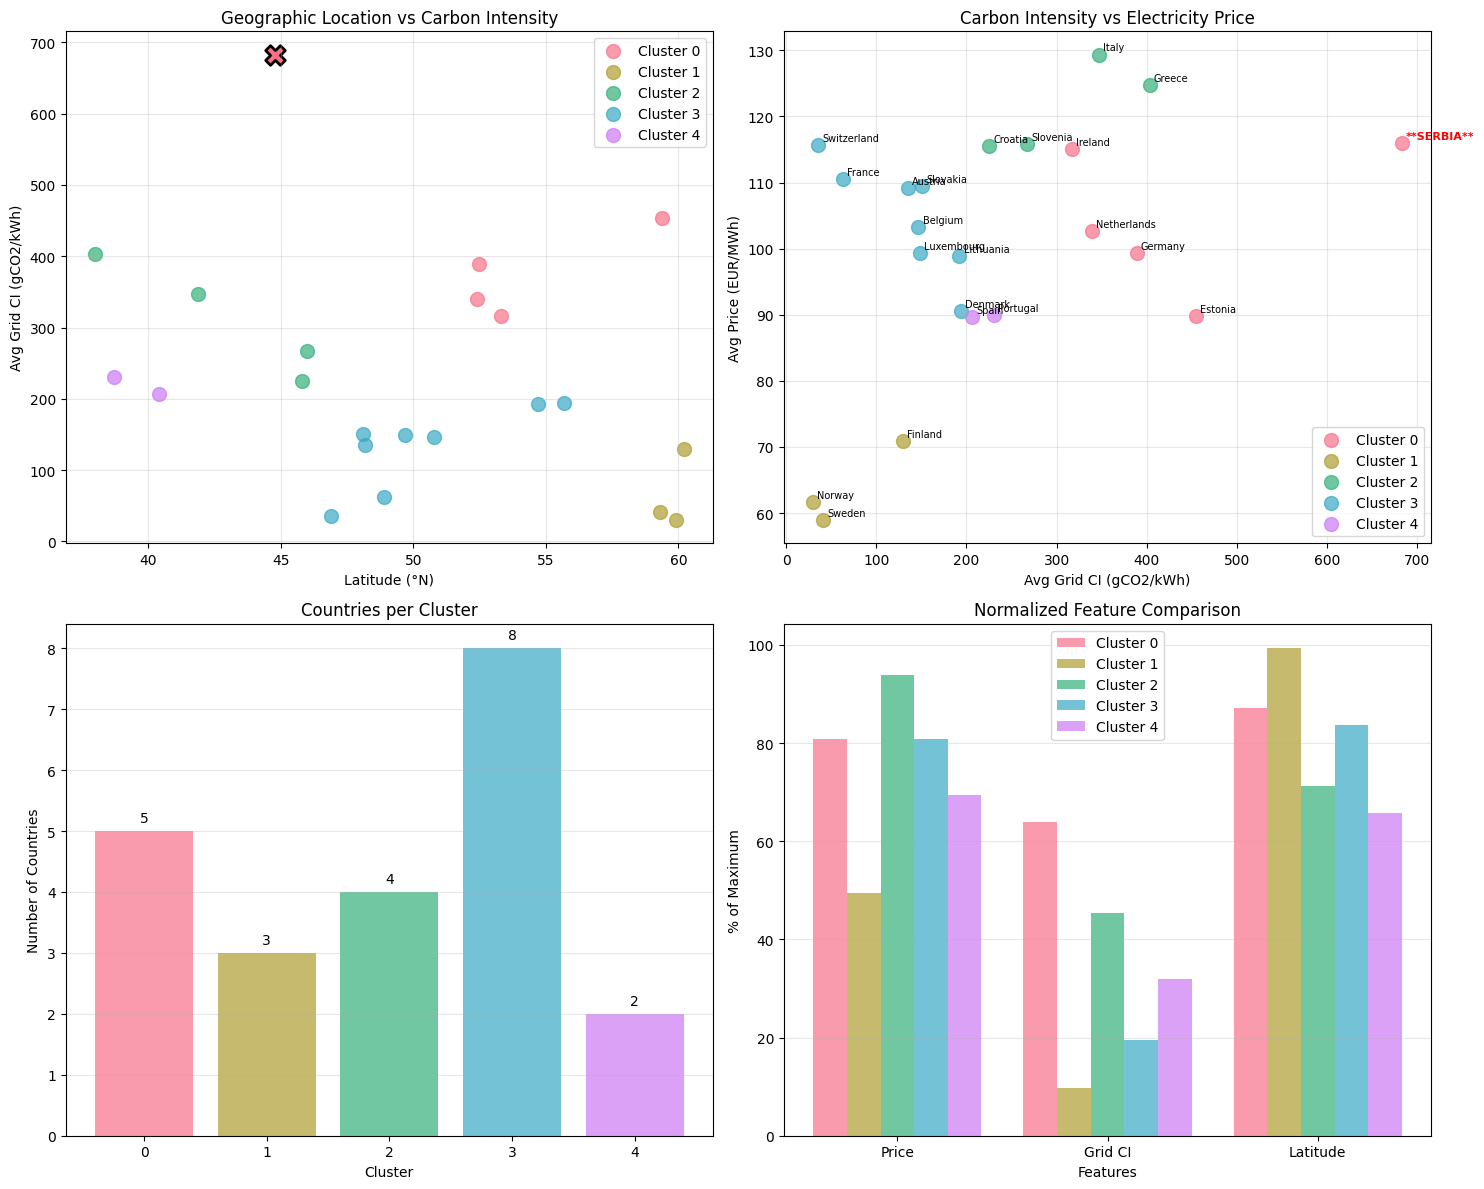


✅ Clustering complete!


In [50]:
# Example usage:
#df, results = run_clustering(df)
# Or specify clusters:
# df, results = cluster_countries_multi_year(df, n_clusters=5)
# Or find optimal:
df, results = cluster_countries_multi_year(df, n_clusters='auto')